In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn,optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from utils import *
# from torchvision.transforms import ToTensor, Lambda



/home/users/lqa/miniconda3/envs/DataScience/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# 在v1基础上给前3个block增加层数
class NN(nn.Module):
    def __init__(self, num_classes):
        super(NN, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (3,3), padding=(1,1), stride=(1,1)),
            nn.BatchNorm2d(num_features = 64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), padding=(1,1), stride=(1,1)),
            nn.BatchNorm2d(num_features = 64),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), padding=(1,1), stride=(1,1)),
            nn.BatchNorm2d(num_features = 64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), padding=(1,1), stride=(1,1)),
            nn.BatchNorm2d(num_features = 128),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3,3), padding=(1,1), stride=(1,1)),
            nn.BatchNorm2d(num_features = 128),           
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3,3), padding=(1,1), stride=(1,1)),
            nn.BatchNorm2d(num_features = 128),           
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3,3), padding=(1,1), stride=(1,1)),
            nn.BatchNorm2d(num_features = 256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3,3), padding=(1,1), stride=(1,1)),
            nn.BatchNorm2d(num_features = 256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3,3), padding=(1,1), stride=(1,1)),
            nn.BatchNorm2d(num_features = 256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3,3), padding=(1,1), stride=(1,1)),
            nn.BatchNorm2d(num_features = 256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.block4 = nn.Sequential(
            nn.Linear(in_features = 256*4*4, out_features = 256),
            nn.ReLU(),
            nn.Linear(in_features = 256, out_features = 128),
            nn.ReLU(),
            nn.Linear(in_features = 128, out_features = 10)
        )
        self.flatten = nn.Flatten()
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(32*32,512),
        #     nn.ReLU(),
        #     nn.Linear(512,512),
        #     nn.ReLU(),
        #     nn.Linear(512,num_classes),
        #     nn.ReLU()
        # )
        
    def forward(self, x):
        # x = self.flatten(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        logits = self.block4(x)
        pred = F.softmax(logits, dim=1)

        return logits,pred

In [3]:

def train_loop(model, train_loader, optimizer, loss_fn, train_loss_list, train_acc_list, device):
    size = len(train_loader.dataset)
    # loss_fn = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss, correct = 0, 0
    model.train()
    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        # print(x.shape)
        # print(y.shape)
        logits, pred = model.forward(x)
        # print(pred.shape)
        y_pred = pred.argmax(dim=1)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * len(x)
        correct += (y_pred == y).type(torch.float).sum().item()
        if i % 100 == 0:
            loss, current = loss.item(), (i+1) * len(x)
            print(f'Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')
    train_loss /= size
    correct /= size
    train_loss_list.append(train_loss)
    train_acc_list.append(correct)

def test_loop(model, test_loader, loss_fn, device, test_loss_list, test_acc_list):
    size = len(test_loader.dataset)
    test_loss, correct = 0,0
    model.eval()

    with torch.no_grad():
        for x,y in test_loader:
            x, y = x.to(device), y.to(device)
            logits, pred = model.forward(x)
            y_pred = pred.argmax(dim=1)
            # print(pred.shape)

            test_loss += loss_fn(pred,y).item() * len(x)
            correct += (y_pred == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size

    test_loss_list.append(test_loss)
    test_acc_list.append(correct)

    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 9)
9
torch.Size([1, 32, 32])


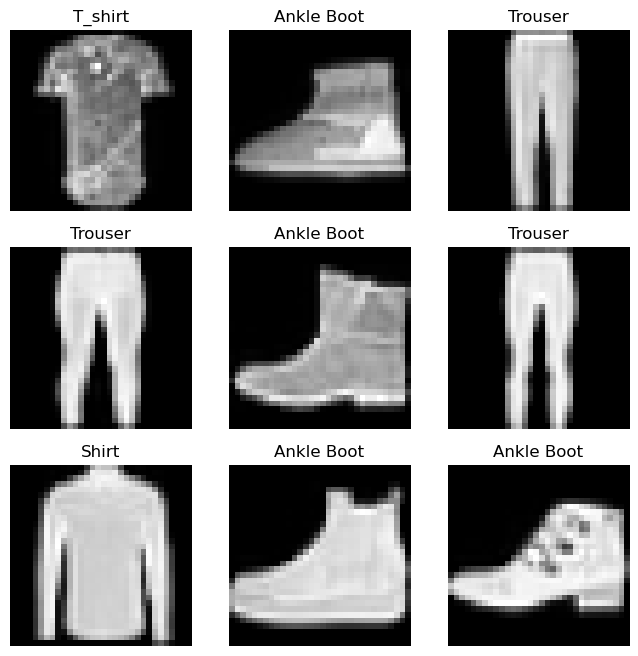

Epoch 1
-------------------------------
Loss: 2.301806  [   64/60000]
Loss: 1.873817  [ 6464/60000]
Loss: 1.805699  [12864/60000]
Loss: 1.748098  [19264/60000]
Loss: 1.731047  [25664/60000]
Loss: 1.767301  [32064/60000]
Loss: 1.726142  [38464/60000]
Loss: 1.736062  [44864/60000]
Loss: 1.773657  [51264/60000]
Loss: 1.774779  [57664/60000]
Test Error: 
 Accuracy: 68.7%, Avg loss: 1.774119 

Epoch 2
-------------------------------
Loss: 1.819692  [   64/60000]
Loss: 1.694078  [ 6464/60000]
Loss: 1.652525  [12864/60000]
Loss: 1.762640  [19264/60000]
Loss: 1.773536  [25664/60000]
Loss: 1.656734  [32064/60000]
Loss: 1.745938  [38464/60000]
Loss: 1.726620  [44864/60000]
Loss: 1.749133  [51264/60000]
Loss: 1.758026  [57664/60000]
Test Error: 
 Accuracy: 72.6%, Avg loss: 1.734875 

Epoch 3
-------------------------------
Loss: 1.772954  [   64/60000]
Loss: 1.739774  [ 6464/60000]
Loss: 1.653487  [12864/60000]
Loss: 1.755053  [19264/60000]
Loss: 1.725133  [25664/60000]
Loss: 1.742399  [32064/600

In [4]:
torch.manual_seed(3312)
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'batch_size': 64,
    # 'test_batch_size': 1000,
    'epochs': 10,
    'lr': 1e-3
}

model = NN(num_classes=10)
model = model.to(args['device'])

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

# trans = [transforms.ToTensor()]
# trans.insert(0, transforms.Resize(32))
# trans = transforms.Compose(trans)
trans = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(32),
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(root='./dataset', train=True,
                                      transform=trans, download=True)
test_dataset = datasets.FashionMNIST(root='./dataset', train=False,
                                     transform=trans, download=True)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=args["batch_size"], shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=args["batch_size"], shuffle=True)


labels_map = {
    0:"T_shirt",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle Boot",
}

print(train_dataset[0])
print(train_dataset[0][1])
print(train_dataset[0][0].shape)
figure = plt.figure(figsize=(8,8))
cols, rows = 3,3
for i in range(1,cols*rows+1):
    sample_idx = torch.randint(len(train_dataset),size=(1,)).item()
    img,label = train_dataset[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(),cmap='gray') # squeeze() can be used to eliminate the dimension whose length is 1
plt.show()


train_acc_list, test_acc_list = [], []
train_loss_list, test_loss_list = [], []
for t in range(args['epochs']):
    print(f'Epoch {t+1}\n-------------------------------')
    train_loop(model, train_loader, optimizer, loss_fn, train_loss_list, train_acc_list, args['device'])
    test_loop(model, test_loader, loss_fn, args['device'], test_loss_list, test_acc_list)
print('Done!')

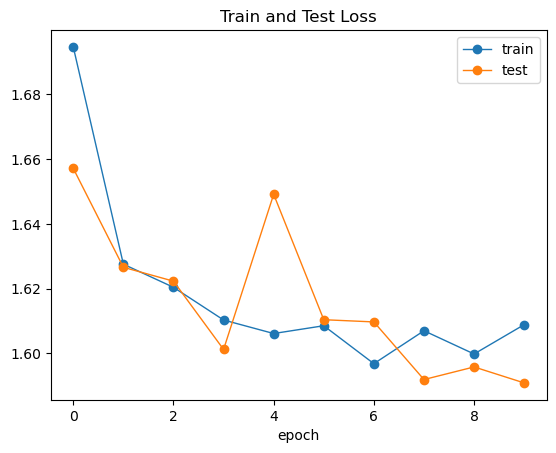

In [8]:
output_root = "./output/v2"
if not os.path.exists(output_root):
    os.mkdir(output_root)
plot_curve(train_acc_list, "Train Accuracy", f"{output_root}/train_acc.pdf")
plot_curve(train_loss_list, "Train Loss",  f"{output_root}/train_loss.pdf")
plot_curve(test_acc_list, "Test Accuracy",  f"{output_root}/test_acc.pdf")
plot_curve(test_loss_list, "Test Loss",  f"{output_root}/test_loss.pdf")

plot_curveII(train_acc_list, test_acc_list, "Train and Test Accuracy",  f"{output_root}/train_test_acc.pdf")
plot_curveII(train_loss_list, test_loss_list, "Train and Test Loss",  f"{output_root}/train_test_loss.pdf")


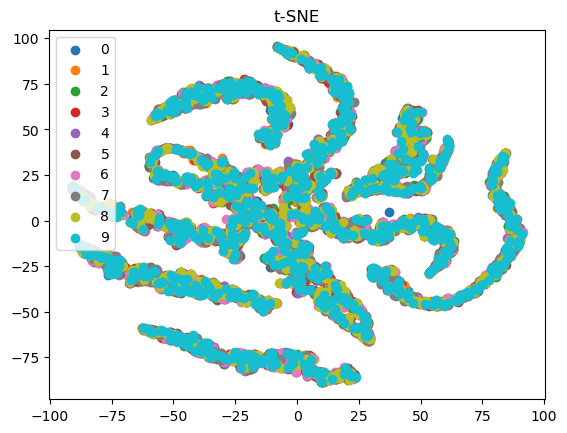

In [10]:
features = []
with torch.no_grad():
    for x,y in test_loader:
        x, y = x.to(args['device']), y.to(args['device'])
        logits, _ = model.forward(x)
        # print(logits.shape)
        features.append(logits.cpu())
tsne = TSNE_myself()
tsne.fit(torch.cat(features, dim = 0))
tsne.visualization(np.array([label for _, label in test_dataset]), savepth=f"{output_root}/tSNE.pdf")